In [1]:
import sys
sys.path.append("../analysis/")

In [2]:
import utils
import extraction
import parsing

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
%matplotlib inline

In [5]:
raw_data = parsing.parse_file("../results/2020-11-05-quals-talk-more-experiments")

In [6]:
raw_data_loads_only = parsing.parse_file("../results/2020-11-05-quals-talk-more-experiments-loads-only")

In [7]:
raw_swinv = parsing.parse_swizzle_inventor_file("../results/2020-06-05-swizzle-inventor-reused-results-new-specs")

In [8]:
## Hack so we get a good comparison
## Move l2 2D stencils to l3 (they have slower search, even) so matrix time is accounted for
import copy
real_raw_data = copy.deepcopy(raw_data)

for i in [3, 5, 7, 9]:
    raw_data[f"specs/swinv_like{'_big' if i >= 7 else ''}/l3/2d-stencil-{i}.swflow"] =\
        raw_data[f"specs/swinv_like{'_big' if i >= 7 else ''}/l2/2d-stencil-{i}.swflow"]

In [9]:
import plots

In [10]:
details_df, comparison_df = plots.process_data(raw_data, raw_data_loads_only, raw_swinv)

In [11]:
comparison_df.head()

,Swizzleflow,Swizzle Inventor
spec,,
l1/1d-conv,0.249351,9.073
l1/1d-stencil,0.235267,6.753
l1/2d-stencil-3,0.022844,21.160
l1/2d-stencil-5,0.155621,65.945
l1/2d-stencil-7,2.205969,634.500


In [12]:
details_df.head()

,Mat. creation,Mat. reuse,Mat. multiply,Search,Reloading all,Total synthesis
spec,,,,,,
l1/1d-conv,0.000567,0.067113,0.171387,0.010283,0.027305,0.249351
l1/1d-stencil,0.000586,0.063468,0.166343,0.004870,0.010500,0.235267
l1/2d-stencil-3,0.005372,0.010624,0.003623,0.003225,0.011242,0.022844
l1/2d-stencil-5,0.045434,0.061284,0.016975,0.031928,0.067986,0.155621
l1/2d-stencil-7,1.794588,0.279207,0.131002,0.001171,0.281963,2.205969


In [13]:
plottable_details = plots.to_plot_df(details_df)

In [14]:
plottable_details.head()

,Problem,Level,Mat. creation,Mat. reuse,Mat. multiply,Search,Reloading all,Total synthesis
0,1D convolution (k=3),R,0.000567,0.067113,0.171387,0.010283,0.027305,0.249351
1,1D stencil (k=3),R,0.000586,0.063468,0.166343,0.004870,0.010500,0.235267
2,2D stencil (k=3),R,0.005372,0.010624,0.003623,0.003225,0.011242,0.022844
3,2D stencil (k=5),R,0.045434,0.061284,0.016975,0.031928,0.067986,0.155621
4,2D stencil (k=7),R,1.794588,0.279207,0.131002,0.001171,0.281963,2.205969


In [15]:
time_components = details_df.sum(axis=0).rename({"Mat. reuse": "Mat. reloading"})

In [16]:
time_components

Mat. creation       617.963369
Mat. reloading        6.333077
Mat. multiply       391.801551
Search               21.487751
Reloading all        44.941317
Total synthesis    1037.585748
dtype: float64

In [17]:
# Sanity checks
time_parts = time_components.drop(['Total synthesis', 'Reloading all'], inplace=False)
time_parts.sum() == time_components['Total synthesis']

True

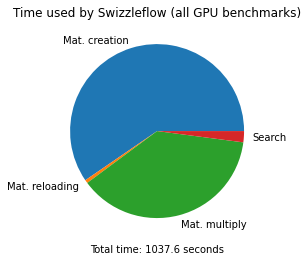

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
time_parts.plot(kind='pie', ax=ax)
ax.set_ylabel("")
ax.set_title("Time used by Swizzleflow (all GPU benchmarks)")
ax.set_xlabel(f"Total time: {time_components['Total synthesis']:.1f} seconds")
ax

In [19]:
fig.savefig("../results/2020-11-05-time-split.pdf")

In [20]:
fig.savefig("../results/2020-11-05-time-split.svg")

In [21]:
plt.close(fig)

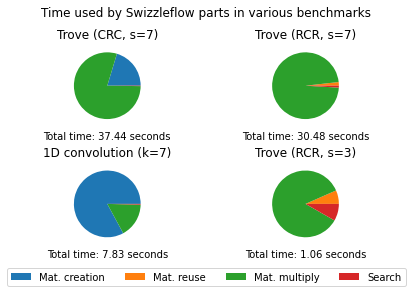

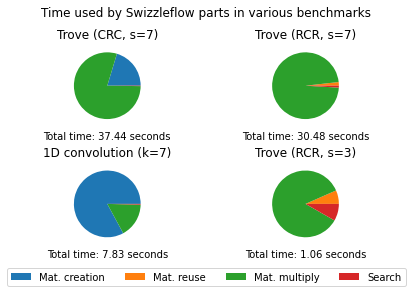

In [22]:
fig, axs = plt.subplots(2, 2)
fig.suptitle("Time used by Swizzleflow parts in various benchmarks")
for idx, group in enumerate([('l3/trove-crc-7', "Trove (CRC, s=7)"),
                            ('l3/trove-rcr-7', "Trove (RCR, s=7)"),
                            ('l3/1d-conv-7', "1D convolution (k=7)"),
                            ('l3/trove-rcr-3', "Trove (RCR, s=3)")]):
    row, title = group
    ax = axs[idx // 2][idx % 2]
    series = details_df.loc[row].drop(["Total synthesis", "Reloading all"])
    series = series.replace(0, 1.0e-9) # Hack, make the colors line up
    series.plot(kind='pie', ax=ax, labels=([''] * len(series)))
    ax.set_ylabel("")
    ax.set_title(title)
    ax.set_xlabel(f"Total time: {details_df['Total synthesis'][row]:.2f} seconds")
fig.tight_layout()
fig.legend(labels=series.index, loc="lower center", ncol=len(series.index))
fig.subplots_adjust(top=0.85, bottom=0.15)
fig.savefig("../results/2020-11-05-time-split.svg")
fig

In [23]:
plt.close(fig)

In [24]:
comparisons_annot = plots.to_plot_df(comparison_df)

In [25]:
full_data = comparisons_annot[comparisons_annot['Level'] == 'F']
full_data

,Problem,Level,Swizzleflow,Swizzle Inventor
28,1D convolution (k=3),F,1.271847,22.879
29,1D stencil (k=3),F,1.221500,15.864
30,2D stencil (k=3),F,0.055568,51.497
31,2D stencil (k=5),F,0.386437,577.110
32,2D stencil (k=7),F,63.682025,NaN
33,"Trove (Sum, s=1)",F,0.000473,8.917
34,"Trove (Sum, s=2)",F,0.115529,15.199
35,"Trove (Sum, s=3)",F,0.283976,23.979
36,"Trove (Sum, s=4)",F,0.983048,34.639
37,"Trove (Sum, s=5)",F,0.882987,49.717


In [26]:
full_data['Swizzle Inventor'] / full_data['Swizzleflow']

28       17.988802
29       12.987307
30      926.736776
31     1493.411688
32             NaN
33    18835.721332
34      131.559757
35       84.440194
36       35.236342
37       56.305477
38       35.151208
39    13151.711311
40       39.059635
41       18.649554
42        2.562687
43       16.234125
44        3.838673
45      798.169306
46      670.420481
47             NaN
48             NaN
49             NaN
50             NaN
dtype: float64

In [27]:
import timing

In [28]:
import importlib
importlib.reload(utils)

<module 'utils' from '../analysis/utils.py'>

In [29]:
gpu_data = timing.process(extraction.humanize_names(raw_data))[['total']]\
   .rename({'total': 'Time'}, axis=1)

In [30]:
our_data = plots.to_plot_df(gpu_data)

In [31]:
our_data

,Problem,Level,Time
0,2D stencil (k=7),FC,63.682025
1,2D stencil (k=9),FC,158.253359
2,"Trove (CRC, s=7)",F,37.443406
3,"Trove (CRC, s=9)",F,123.519346
4,2D stencil (k=7),F,63.682025
...,...,...,...
64,"Trove (Sum, s=4)",R,0.883055
65,"FFM (w=4, registers)",R,0.002718
66,"Trove (Sum, s=9)",F,3.965552
67,"Trove (Sum, s=11)",F,22.723501


In [32]:
full_data = our_data[our_data['Level'] == 'F'].set_index('Problem')['Time'].sort_index(inplace=False)
full_data

Problem
1D convolution (k=11)     20.454559
1D convolution (k=13)     28.046552
1D convolution (k=3)       1.271847
1D convolution (k=5)       3.874825
1D convolution (k=7)       7.834212
1D convolution (k=9)      26.881445
1D stencil (k=3)           1.221500
2D stencil (k=3)           0.055568
2D stencil (k=5)           0.386437
2D stencil (k=7)          63.682025
2D stencil (k=9)         158.253359
FFM (w=4, registers)       0.003509
FFM (w=8, registers)       2.728529
Trove (CRC, s=1)           0.000302
Trove (CRC, s=2)           0.223812
Trove (CRC, s=3)           0.913641
Trove (CRC, s=4)           8.063021
Trove (CRC, s=5)           7.402925
Trove (CRC, s=7)          37.443406
Trove (CRC, s=9)         123.519346
Trove (RCR, s=1)           0.012050
Trove (RCR, s=2)           2.297327
Trove (RCR, s=3)           1.059690
Trove (RCR, s=4)           7.884500
Trove (RCR, s=5)          10.911200
Trove (RCR, s=7)          30.479107
Trove (RCR, s=9)         102.644953
Trove (Sum, s=1)    

In [33]:
full_data["HVX Gaussian"] = 0.616050414

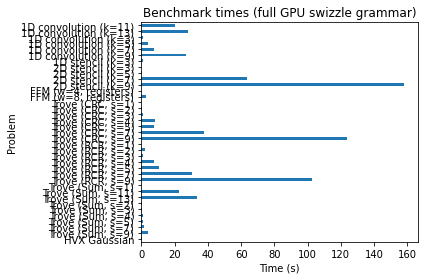

In [34]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
full_data.iloc[::-1].plot(kind='barh', ax=ax)
ax.set_xlabel("Time (s)")
ax.set_title("Benchmark times (full GPU swizzle grammar)")
fig.tight_layout()
fig.savefig("/tmp/full-swflow.png")
fig.savefig("/tmp/full-swflow.pdf")
ax

In [35]:
fig.savefig("/tmp/full-swflow.pdf")

In [36]:
import re

In [37]:
def to_task_and_size(problem):
    match_trove = re.match(r'Trove \((\w+), s=(\d+)\)', problem)
    if match_trove is not None:
        return (f"Trove ({match_trove[1]})", int(match_trove[2]))
    match_ffm = re.match(r'FFM \(w=(\d+), registers\)', problem)
    if match_ffm is not None:
        return ("FFM (registers)", int(match_ffm[1]))
    match_2d_stencil = re.match(r'2D stencil \(k=(\d+)\)', problem)
    if match_2d_stencil is not None:
        return ("2D Stencil", int(match_2d_stencil[1]))
    match_1d_conv = re.match(r'1D convolution \(k=(\d+)\)', problem)
    if match_1d_conv is not None:
        return("1D Convolution", int(match_1d_conv[1]))
    return ("Misc", problem)
    

In [38]:
to_task_and_size("Trove (RCR, s=5)")

('Trove (RCR)', 5)

In [39]:
full_data.index.map(to_task_and_size).rename(['Task', 'Size'])

MultiIndex([( '1D Convolution',                 11),
            ( '1D Convolution',                 13),
            ( '1D Convolution',                  3),
            ( '1D Convolution',                  5),
            ( '1D Convolution',                  7),
            ( '1D Convolution',                  9),
            (           'Misc', '1D stencil (k=3)'),
            (     '2D Stencil',                  3),
            (     '2D Stencil',                  5),
            (     '2D Stencil',                  7),
            (     '2D Stencil',                  9),
            ('FFM (registers)',                  4),
            ('FFM (registers)',                  8),
            (    'Trove (CRC)',                  1),
            (    'Trove (CRC)',                  2),
            (    'Trove (CRC)',                  3),
            (    'Trove (CRC)',                  4),
            (    'Trove (CRC)',                  5),
            (    'Trove (CRC)',               

In [40]:
full_data_split = full_data.copy()
full_data_split.index = full_data_split.index.map(to_task_and_size).rename(['Task', 'Size'])
full_data_split = full_data_split.reset_index()

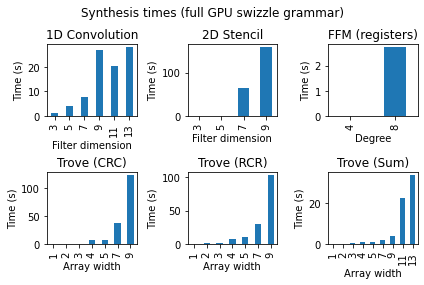

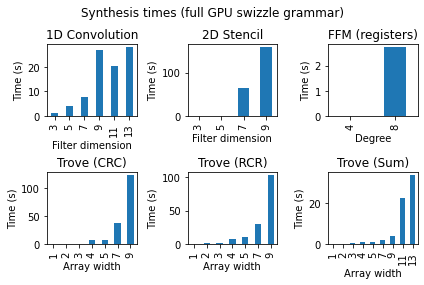

In [41]:
fig, axs = plt.subplots(2, 3)
seen_misc = False
for (idx, group) in enumerate(full_data_split.groupby('Task')):
    task, df = group
    if task == "Misc":
        seen_misc = True
        continue
    if seen_misc:
        idx = idx - 1
    ax = axs[idx // 3][idx % 3]
    df.set_index('Size').sort_index()['Time'].plot(kind='bar', ax=ax)
    ax.set_title(task)
    ax.set_ylabel("Time (s)")
    if task.startswith("Trove"):
        ax.set_xlabel("Array width")
    elif task.startswith("FFM"):
        ax.set_xlabel("Degree")
    elif task.startswith("2D") or task.startswith("1D"):
        ax.set_xlabel("Filter dimension")
    else:
        ax.set_xlabel("Problem")
fig.suptitle("Synthesis times (full GPU swizzle grammar)")
fig.tight_layout()
fig.subplots_adjust(top=0.85)
fig.savefig("../results/2020-11-05-full-synthesis-times.svg")
fig

In [42]:
plt.close(fig)

In [43]:
misc_full = full_data_split[full_data_split["Task"] == "Misc"]

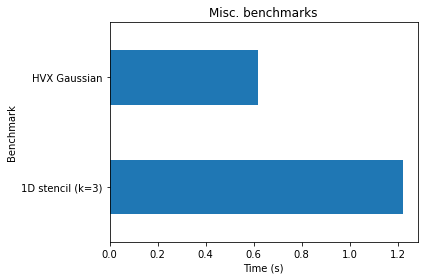

In [44]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
misc_full.set_index("Size")[["Time"]].plot(kind='barh', ax=ax, legend=False)
ax.set_title("Misc. benchmarks")
ax.set_ylabel("Benchmark")
ax.set_xlabel("Time (s)")
fig.tight_layout()
fig.savefig("../results/2020-11-05-misc-times.svg")

In [45]:
plt.close(fig)

In [46]:
df = comparisons_annot[comparisons_annot["Level"] == "F"]

In [47]:
df = df.set_index("Problem").drop(columns=['Level'])

In [48]:
df.index = df.index.map(to_task_and_size).rename(['Task', 'Size'])
df = df.reset_index()

2D Stencil 0
Trove (CRC) 1
Trove (RCR) 2
Trove (Sum) 3


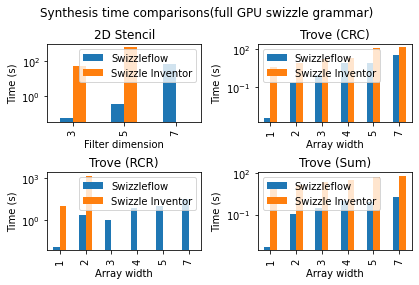

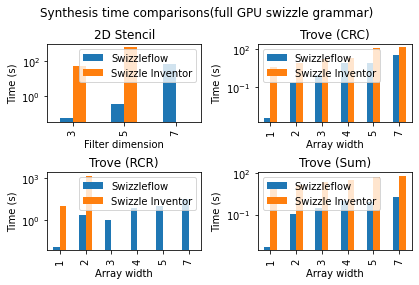

In [49]:
fig, axs = plt.subplots(2, 2)
delta = 0
for (idx, group) in enumerate(df.groupby('Task')):
    task, subdf = group
    if task == 'Misc' or task.startswith("1D"):
        delta = delta + 1
        continue
    idx = idx - delta
    print(task, idx)
    ax = axs[idx // 2][idx % 2]
    subdf.set_index('Size')[['Swizzleflow', 'Swizzle Inventor']].plot(kind='bar', ax=ax, logy=True)
    ax.set_title(task)
    ax.set_ylabel("Time (s)")
    if task.startswith("Trove"):
        ax.set_xlabel("Array width")
    elif task.startswith("2D"):
        ax.set_xlabel("Filter dimension")
    else:
        ax.set_xlabel("Problem")
fig.suptitle("Synthesis time comparisons(full GPU swizzle grammar)")
fig.tight_layout()
fig.subplots_adjust(top=0.85)
fig.savefig("/tmp/full-comparisons.png")
fig

In [50]:
df_indexed = df.set_index(['Task', 'Size'])

In [51]:
df_indexed['Swizzle Inventor'] / df_indexed['Swizzleflow']

Task            Size            
1D Convolution  3                      17.988802
Misc            1D stencil (k=3)       12.987307
2D Stencil      3                     926.736776
                5                    1493.411688
                7                            NaN
Trove (Sum)     1                   18835.721332
                2                     131.559757
                3                      84.440194
                4                      35.236342
                5                      56.305477
                7                      35.151208
Trove (CRC)     1                   13151.711311
                2                      39.059635
                3                      18.649554
                4                       2.562687
                5                      16.234125
                7                       3.838673
Trove (RCR)     1                     798.169306
                2                     670.420481
                3                   

In [52]:
comparisons_annot[comparisons_annot['Level'] == 'FC']

,Problem,Level,Swizzleflow,Swizzle Inventor
23,1D convolution (k=3),FC,0.943547,10.751
24,1D stencil (k=3),FC,0.941344,11.641
25,2D stencil (k=3),FC,0.055568,45.934
26,2D stencil (k=5),FC,0.386437,138.076
27,2D stencil (k=7),FC,63.682025,851.822


In [53]:
851 / 63

13.507936507936508

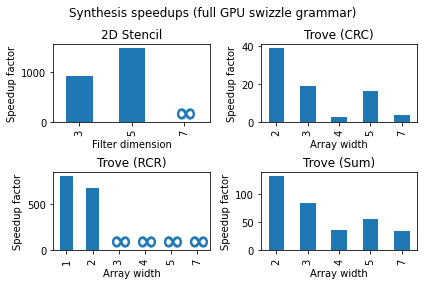

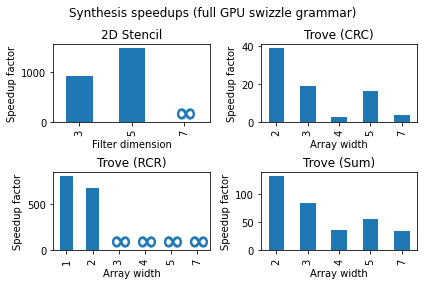

In [54]:
def speedup_plots(df, grammar_desc):
    fig, axs = plt.subplots(2, 2)
    delta = 0
    for (idx, group) in enumerate(df.groupby('Task')):
        task, subdf = group
        if task == 'Misc' or task.startswith("1D"):
            delta = delta + 1
            continue
        idx = idx - delta
        ax = axs[idx // 2][idx % 2]
        subdf = subdf.set_index('Size')
        if task == "Trove (CRC)" or task == "Trove (Sum)":
            subdf.drop(index=[1], inplace=True)
        speedup = subdf['Swizzle Inventor'] / subdf['Swizzleflow']
        speedup.name = "Speedup"
        speedup.plot(kind='bar', ax=ax)
        timeout = pd.isnull(speedup)
        timeout = timeout.map({True: speedup.max() / 10, False: np.nan})
        timeout.name = "Timeout"
        ax.plot(range(len(timeout)), timeout,
                marker='$∞$', linestyle="", markersize=20)
        ax.set_title(task)
        ax.set_ylabel("Speedup factor")
        if task.startswith("Trove"):
            ax.set_xlabel("Array width")
        elif task.startswith("2D"):
            ax.set_xlabel("Filter dimension")
        else:
            ax.set_xlabel("Problem")
    fig.suptitle(f"Synthesis speedups ({grammar_desc} GPU swizzle grammar)")
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    return fig
fig = speedup_plots(df, "full")
fig.savefig("/tmp/speedups.png")
fig

In [55]:
plt.close(fig)

In [56]:
df = comparisons_annot[comparisons_annot["Level"] == "R"]
df = df.set_index("Problem").drop(columns=['Level'])
df.index = df.index.map(to_task_and_size).rename(['Task', 'Size'])
df = df.reset_index()

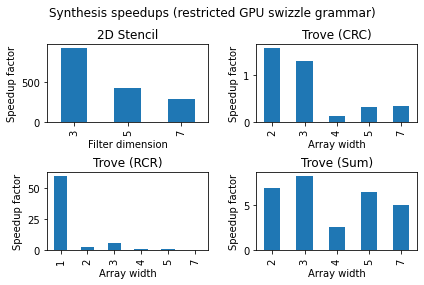

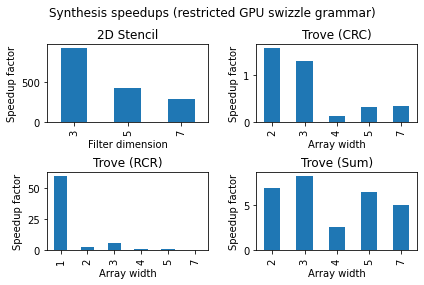

In [57]:
speedup_plots(df, "restricted")